## Regularizing ill-Posed Inverse Gravity Anomaly Problem using LASSO, Ridge Regression and Elastic Net

In [197]:
# Loading the data and checking the shape of individual matrices

import h5py
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
filename = 'gravity_data.h5'

with h5py.File(filename, "r") as f:
    G_group_key = list(f.keys())[0]
    d_group_key = list(f.keys())[1]
    print(list(f.keys()))
    G = np.array(f[G_group_key])
    d = np.array(f[d_group_key])

print("Shape: ",G.shape, d.shape)

['G', 'd']
Shape:  (20301, 201) (201,)


It can be seen that the shape of the matrix G is 20301x201, we need to atleast transpose it and use. After transposing the matrix will have same number of rows as in the data matrix i.e 201

In [198]:
G_ = np.transpose(G)
print(G_.shape)

(201, 20301)


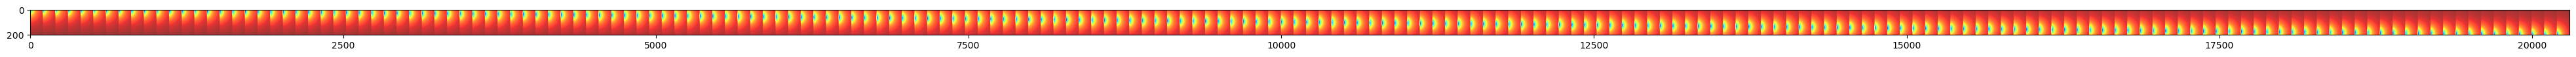

In [199]:
plt.rcParams['figure.figsize'] = [50, 50]
plt.imshow(G_, alpha=0.8, cmap='jet')
plt.show()

The shape of G matrix is 201x20301 and the m is 201x1  which corresponds to 201 linear equations and 20301 parameters, the system is underdetermined and hence **ill-posed** .

After color/heatmap plot of G matrix, it can be seen there are bumps or sudden changes of values after every 101 rows which means that during the construction the G matrix with $\psi$ values first the values along $z$ are stored one beside the other, before moving on to the next $x$ position. This information needs to be taken care of in the reshaping operation of m in order to plot it.

Shape(U) =  (201, 201) Shape(s) =  (201,) Shape(Vh) =  (20301, 20301)


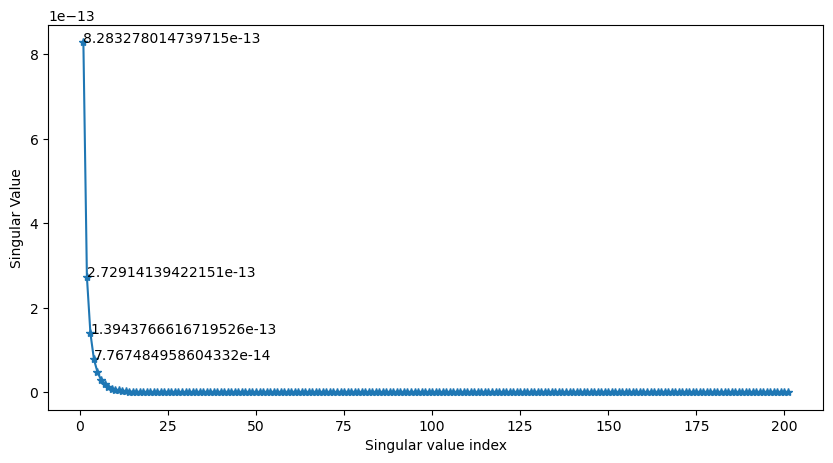

In [200]:
from scipy import linalg as la
U,s,Vh = la.svd(G_)

print('Shape(U) = ',U.shape, 'Shape(s) = ', s.shape, 'Shape(Vh) = ',Vh.shape)

x = np.arange(1,202,1)

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(x,s,'-*')
plt.xlabel('Singular value index')
plt.ylabel('Singular Value')
for i,j in zip(x[0:4],s[0:4]):
    plt.annotate(str(j),xy=(i,j))

plt.show()

In [201]:
print((np.sum(s[0:4]**2)/np.sum(s**2))*100)   

99.51396151170717


After performing SVD it can be seen that ~99% of the information is contained in the first 4 singular values.

In [202]:
#A test to determine how the reshaping operation will take place, first the columns are created followed by rows

a = np.random.randint(100, size = (100,1))
print(a[0:10])
b = np.reshape(a,(5,20), order='F')
print(b)

[[93]
 [35]
 [27]
 [42]
 [60]
 [61]
 [32]
 [27]
 [15]
 [87]]
[[93 61 69 26 98 87 25 54 74  1  2 82 15 48 34  5 10 80 77 41]
 [35 32 19 33 81 95 49 64 90 36 18 46 26 95 26 98 55 88 47 69]
 [27 27 98 65  5 88 98 77 66 30  5  7 56 56 92 30 20 89 24 89]
 [42 15 49 58  6 74 94 33 34 47 15 11 40 25 24 10  0 32 31 51]
 [60 87 86 28 82 57 94 33 99 94 32 27  5 23  8 42 81 49 61 67]]


The pseudo inverse can be calculated using the decomposed $U$,$\sigma$,$V^T$ matrix but we use the standard pinv function instead.

(20301,)
m_pinv after reshaping:  (101, 201)


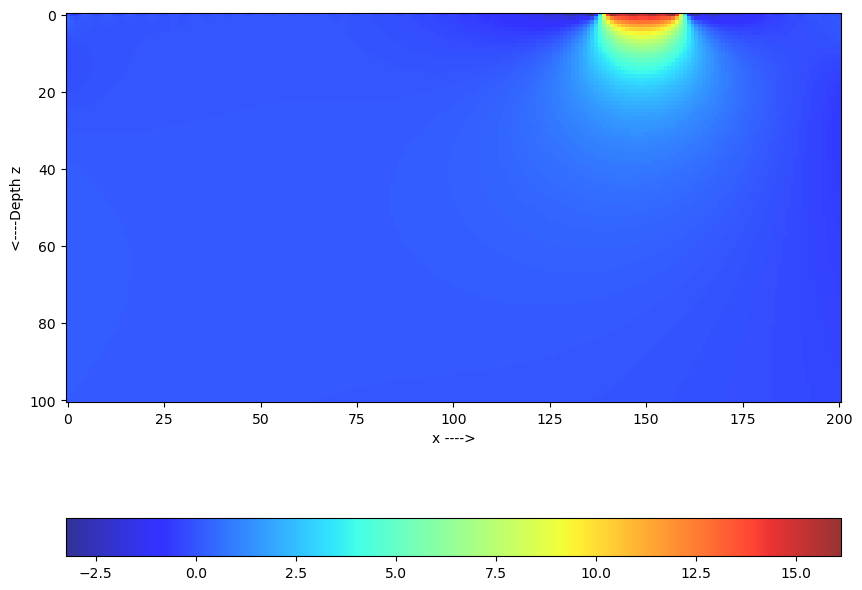

In [203]:
G_inv = la.pinv(G_)
m_pinv = G_inv@d   #Estimated value of m after pre-multiplying G_inv with d
print(m_pinv.shape)

m_pinv_reshaped = np.reshape(m_pinv,(101,201),order = 'F') #first columns are made followed by rows
print('m_pinv after reshaping: ',m_pinv_reshaped.shape)

plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(m_pinv_reshaped, alpha=0.8, cmap='jet')
plt.xlabel('x ---->')
plt.ylabel('<----Depth z')
plt.colorbar(location = 'bottom')
plt.show()

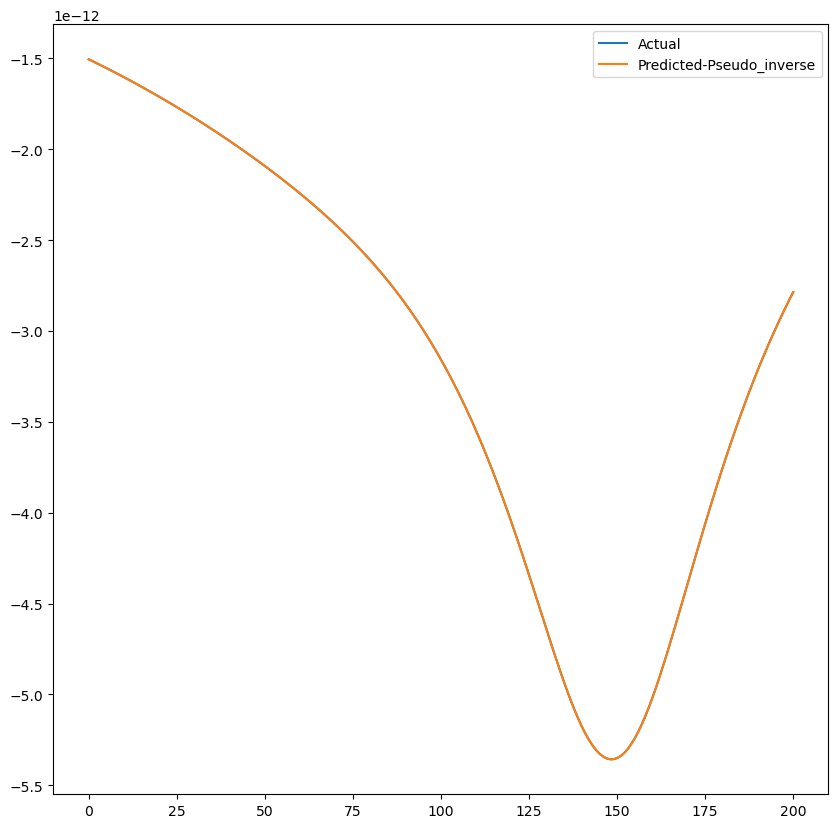

In [204]:
d_predicted_pinv = G_@m_pinv
d.shape
x_km = np.arange(0,201,1)
x_km.shape
plt.plot(x_km,d, label='Actual')
plt.plot(x_km,d_predicted_pinv, label = 'Predicted-Pseudo_inverse')
plt.legend()
plt.show()

In [205]:
from sklearn.metrics import r2_score
print(r2_score(d, d_predicted_pinv))

0.9999999999999919


R2 score determines the **confidence** we can put in this prediction or best of fit.

In [206]:
print('d : ',np.min(d),np.max(d))
print('G: ', np.min(G_),np.max(G_))

d :  -5.356930301016555e-12 -1.5047991268483303e-12
G:  -1.6687699999999999e-15 -1.4309584696413224e-16


The order is too small(~10e-16) which can cause convergence issues so it needs to be scaled.

In [207]:
def scale(arr):
    arr = arr / np.min(G_)
    return arr

x = G_
y = d

## Ridge Regression

$$J = \frac{1}{2}{{||y - Xw||_{2}^2}} +  \alpha *  {{||w||}_{2}}^2$$

A slider is used to vary the values of the parameter alpha to find out the best fit, Ridge regression along a path is not directly available

In [208]:
from sklearn.linear_model import Ridge

def plot_elastic(alpha):
    regr = Ridge(alpha = alpha, max_iter = 10000)
    regr.fit(scale(x), scale(y))
    m_ridge = regr.coef_

    m_ridge_reshaped = np.reshape(m_ridge,(101,201), order = 'F')
    plt.imshow(m_ridge_reshaped, alpha=0.8, cmap='jet')
    plt.xlabel('x ---->')
    plt.ylabel('<----Depth z')
    plt.colorbar(location = 'bottom')
    plt.show()

    d_ridge_pred = G_@m_ridge
    plt.plot(x_km,d_ridge_pred, label = 'Ridge_predicted')
    plt.plot(x_km,d, label='Actual')
    plt.xlabel('Position x---->')
    plt.ylabel('Gravitational Potential')
    plt.legend()
    plt.title('R2 Score = '+str(r2_score(d, d_ridge_pred)))
    plt.show()


interact(plot_elastic, alpha = (0.1,2,0.1))

interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0, min=0.1), Output()), _dom_classes=(…

<function __main__.plot_elastic(alpha)>

Both ridge regression and pseudo inverse gives a reasonable $R^2 > 0.99$, but the density anomaly found out is diffused, if we want solid boundaries Lasso parameters needs tuning to get better R2

## Lasso

$$J = \frac{1}{2*n_{samples}}{{||y - Xw||_{2}^2}} +  \alpha *  {{||w||}_{1}}$$

Multiple $\alpha$ values are tested.

In [209]:
from sklearn.linear_model import lasso_path

alphas_lasso,coefs_lasso,b = lasso_path(scale(x),scale(y))

print(alphas_lasso.shape,coefs_lasso.shape)

r2_scores_lasso = []
for i in range(0,100):
    m_lasso = coefs_lasso[:,i]
    m_lasso_reshaped = np.reshape(coefs_lasso[:,i],(101,201), order = 'F')
    d_lasso_pred = G_@m_lasso
    r2_score_lasso = r2_score(d, d_lasso_pred)
    r2_scores_lasso.append(r2_score_lasso)

print("Last 5 values of alpha and accuracy for Lasso path")
for i in range(95,100):
    print('R2 Score = ',r2_scores_lasso[i],'alpha = ',alphas_lasso[i], 'index = ',i)


(100,) (20301, 100)
Last 5 values of alpha and accuracy for Lasso path
R2 Score =  0.999901024055502 alpha =  1.3649217957875084 index =  95
R2 Score =  0.9999093675596079 alpha =  1.2729306349852851 index =  96
R2 Score =  0.9999171496238543 alpha =  1.1871393705374593 index =  97
R2 Score =  0.9999238624776773 alpha =  1.1071301501800734 index =  98
R2 Score =  0.9999301141869722 alpha =  1.0325132834932582 index =  99


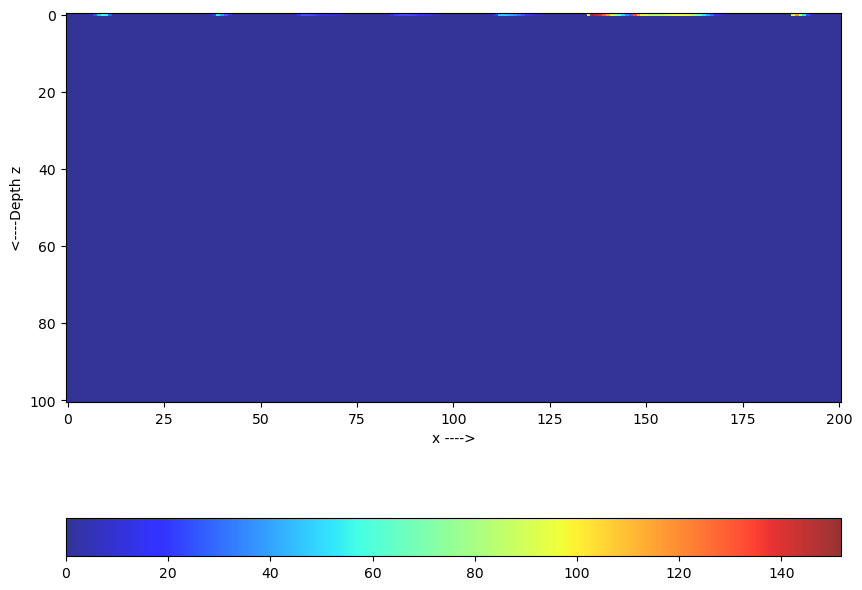

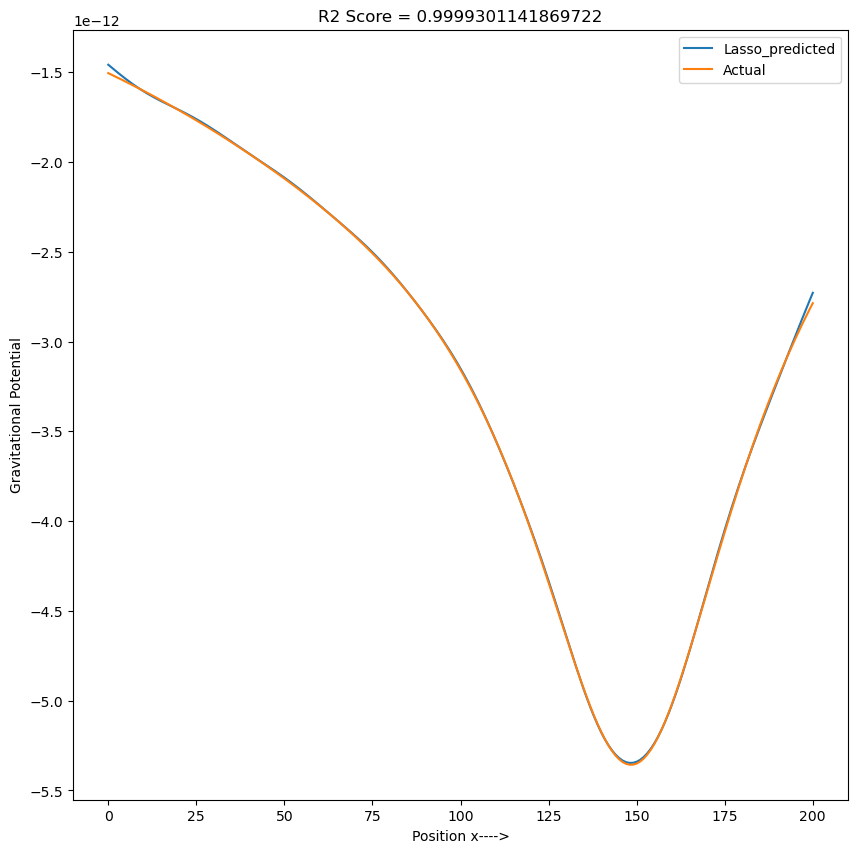

In [210]:
m_lasso = coefs_lasso[:,99]
m_lasso_reshaped = np.reshape(coefs_lasso[:,99],(101,201), order = 'F')
d_lasso_pred = G_@m_lasso

plt.imshow(m_lasso_reshaped, alpha=0.8, cmap='jet')
plt.xlabel('x ---->')
plt.ylabel('<----Depth z')
plt.colorbar(location = 'bottom')
plt.show()

plt.plot(x_km,d_lasso_pred, label = 'Lasso_predicted')
plt.plot(x_km,d, label='Actual')
plt.legend()
plt.xlabel('Position x---->')
plt.ylabel('Gravitational Potential')
plt.title('R2 Score = '+str(r2_score(d, d_lasso_pred)))
plt.show()

Lasso gives a solution in which the density anomaly is spread out at $z=0$, with majority of it lying near $x=150$ units.
The discrete chunks as output rather than diffused ones is clear display of Lasso's working principle where it removes the values having magnitude below a particular threshold.

## Elastic Net
This module optimizes the following cost function

$$J = \frac{1}{(2 * n_{samples})} * {{||y - Xw||_{2}^2}} + \alpha * {l1}_{ratio} * {||w||}_{1} + {\frac{1}{2}} * \alpha * (1 - l1_{ratio}) * {{||w||}_{2}}^2$$


In [211]:
from sklearn.linear_model import enet_path
from sklearn.metrics import r2_score

num_alphas=500
# alpha_list = np.arange(3,0.01,-0.01)
#alphas_enet,coefs_enet,b = enet_path(scale(x),scale(y), alphas=alpha_list, l1_ratio=0.5)

alphas_enet,coefs_enet,b = enet_path(scale(x),scale(y), n_alphas=num_alphas, l1_ratio=0.5, eps=1e-4)
print(alphas_enet.shape,coefs_enet.shape)

r2_scores_enet = []
for i in range(0,num_alphas):
    m_enet = coefs_enet[:,i]
    m_enet_reshaped = np.reshape(coefs_enet[:,i],(101,201), order = 'F')
    d_enet_pred = G_@m_enet
    r2_score_enet = r2_score(d, d_enet_pred)
    r2_scores_enet.append(r2_score_enet)

    
print("Last 5 values of alpha and accuracy for ElasticNet path")
for i in range(num_alphas-5,num_alphas):
    print('R2 Score = ',r2_score_enet,'alpha = ',alphas_enet[i], 'index = ',i)

(500,) (20301, 500)
Last 5 values of alpha and accuracy for ElasticNet path
R2 Score =  0.9996502246779759 alpha =  0.22232575282589417 index =  495
R2 Score =  0.9996502246779759 alpha =  0.21825979326632822 index =  496
R2 Score =  0.9996502246779759 alpha =  0.21426819318572451 index =  497
R2 Score =  0.9996502246779759 alpha =  0.21034959267579317 index =  498
R2 Score =  0.9996502246779759 alpha =  0.20650265669865162 index =  499


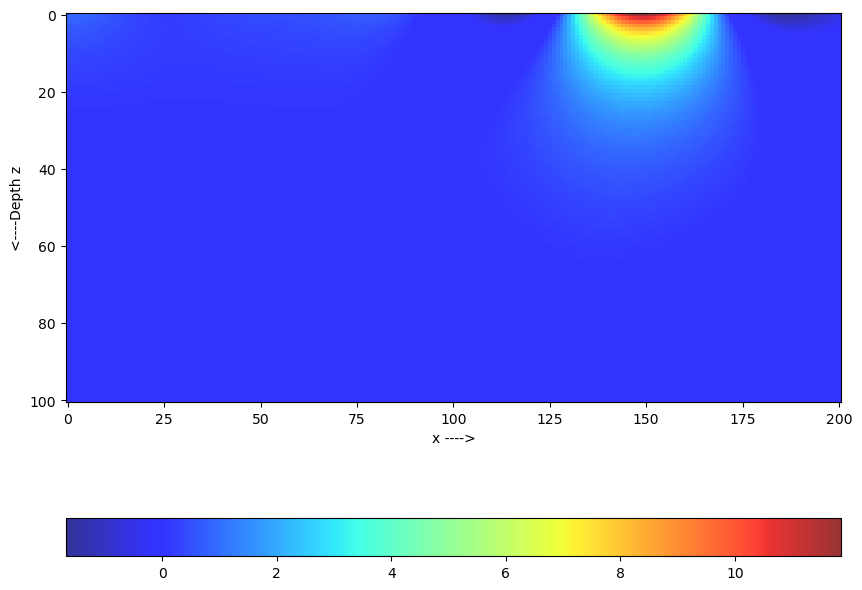

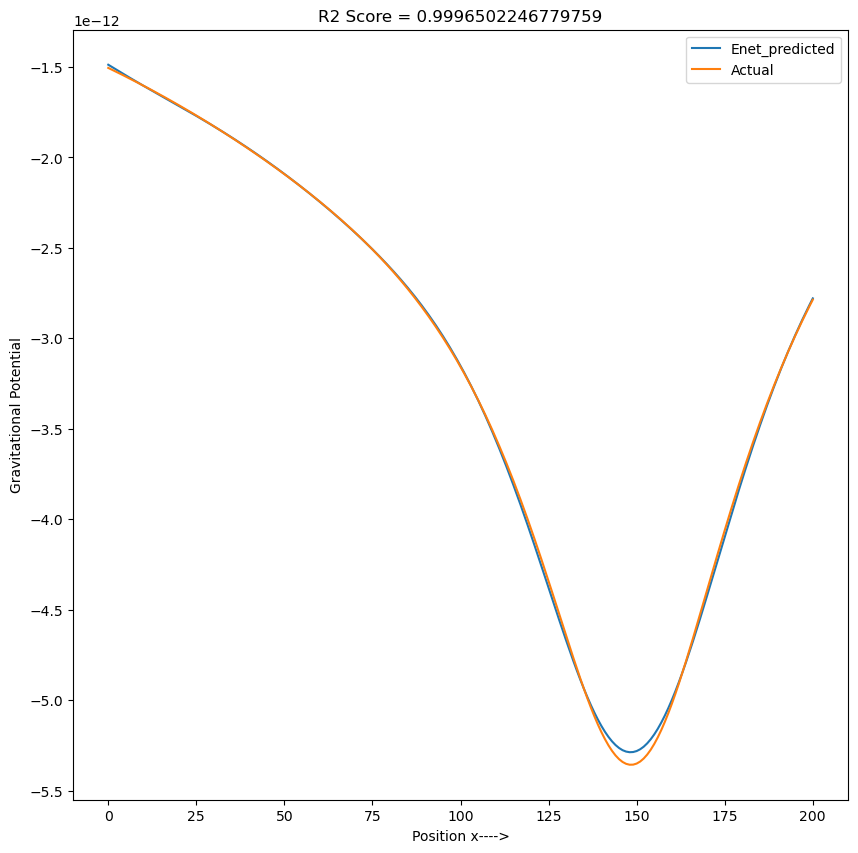

In [212]:
m_enet = coefs_enet[:,num_alphas-1]
m_enet_reshaped = np.reshape(m_enet,(101,201), order = 'F')
d_enet_pred = G_@m_enet

plt.imshow(m_enet_reshaped, alpha=0.8, cmap='jet')
plt.xlabel('x ---->')
plt.ylabel('<----Depth z')
plt.colorbar(location = 'bottom')
plt.show()

plt.plot(x_km,d_enet_pred, label = 'Enet_predicted')
plt.plot(x_km,d, label='Actual')
plt.legend()
plt.xlabel('Position x---->')
plt.ylabel('Gravitational Potential')
plt.title('R2 Score = '+str(r2_score(d, d_enet_pred)))
plt.show()

All of the algorithms converge on the fact that the data can be explained by a positive density anomaly at $x = 150$ units. But since this is a underdetermined problem it can have infinite number of solutions in which rather than density being concentrated at a region it is spread out/scattered and discontinuous. If we put further constraints such as density lying between $0-100 \frac{Kg}{m^3}$, most likely solution is something similar to what we found out previously.

To display that there are infinite number of solutions to the density matrix, lasso is iteratively run in a random selection mode to get a r2 score <0.999.

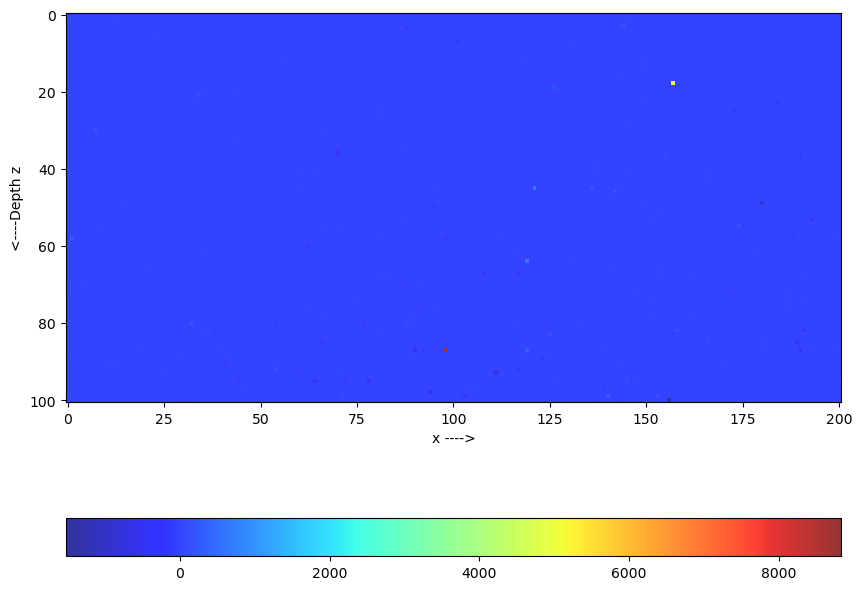

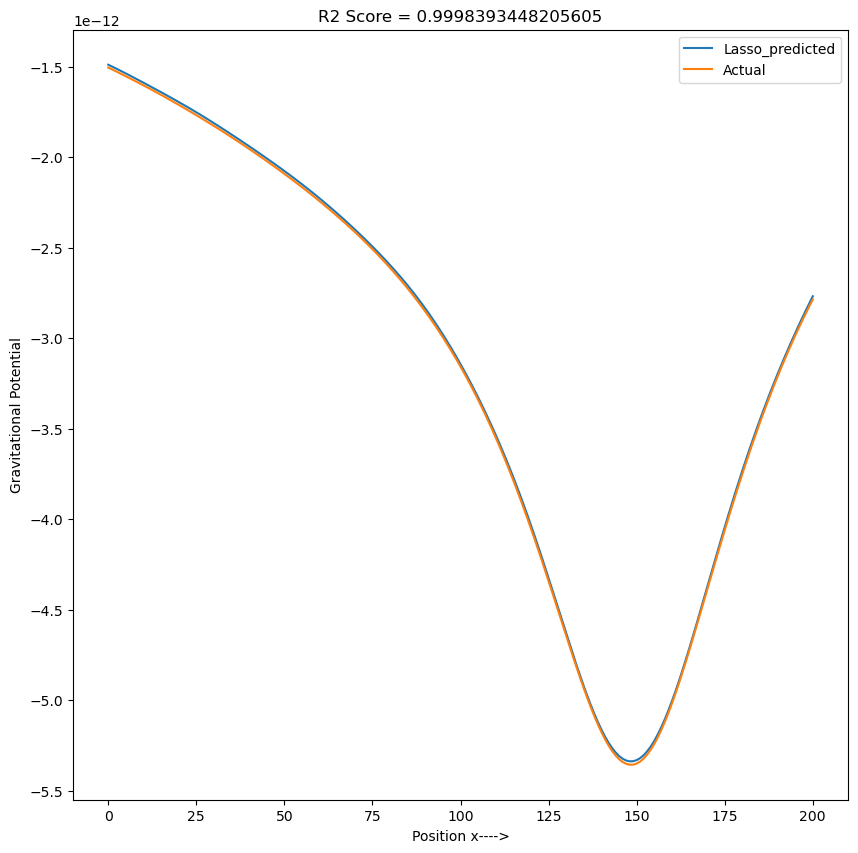

In [238]:
from sklearn.linear_model import Lasso

d_lasso_pred_random = d*0
while((r2_score(d, d_lasso_pred_random))<0.999):
    regr = Lasso(alpha = 1e-6, max_iter = 10000, selection='random')
    regr.fit(scale(x), scale(y))
    m_lasso = regr.coef_
    d_lasso_pred_random = G_@m_lasso

m_lasso_reshaped = np.reshape(m_lasso,(101,201), order = 'F', )
plt.imshow(m_lasso_reshaped, alpha=0.8, cmap='jet')
plt.xlabel('x ---->')
plt.ylabel('<----Depth z')
plt.colorbar(location = 'bottom')
plt.show()

plt.plot(x_km,d_lasso_pred_random, label = 'Lasso_predicted')
plt.plot(x_km,d, label='Actual')
plt.legend()
plt.xlabel('Position x---->')
plt.ylabel('Gravitational Potential')
plt.title('R2 Score = '+str(r2_score(d, d_lasso_pred_random)))
plt.show()



In this particular solution the density anomalies are scattered all over the place but with values beyond the acceptable range of $0-100 \frac{Kg}{m^3}$